# Lunar P and PcP Sensitivity Kernels

This notebook demonstrates how to compute and visualise travel-time sensitivity kernels
(Fréchet derivatives) for **P** and **PcP** wave phases on the Moon, using the
[SensRay](https://github.com/Adrian-Mag/SensRay) package.

**Workflow**
1. Load the `weber_core` lunar velocity model (includes a lunar core).
2. Generate a 1D spherical mesh from the model's discontinuity structure.
3. Populate seismic properties (`vp`, `vs`, `rho`) on the mesh.
4. Define 3 Apollo-like stations and 3 synthetic seismic events.
5. Compute P and PcP ray paths for every station–event pair.
6. Plot stations and events on a 3-D lunar sphere.
7. Plot ray paths in a polar (r–θ) cross-section.
8. Compute per-shell sensitivity kernels and visualise them.


## 1 · Import required libraries

In [1]:

import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), ''))  # ensure SensRay is importable

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 – registers 3-D projection
import seaborn as sns

from sensray import PlanetModel, PlanetMesh

print("SensRay imported OK")
print(f"Available standard models: {PlanetModel.list_standard_models()}")


/home/adrian/miniconda3/envs/masters/lib/python3.11/site-packages/obspy/core/util/base.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


SensRay imported OK
Available standard models: ['1066a', '1066b', 'M1', 'M2', 'M2_resampled_on_M1', 'M3', 'M3_resampled_on_M1', 'ak135favg', 'ak135fcont', 'ak135fsyngine', 'alfs', 'herrin', 'jb', 'prem', 'pwdk', 'weber_core', 'weber_core_resampled_on_M1', 'weber_core_smooth', 'weber_core_smooth_resampled_on_M1']


## 2 · Load the lunar velocity model

We use the `weber_core` model — a 1-D lunar model that includes a mantle, outer-core, and inner-core,
making it possible to trace **PcP** reflections off the core–mantle boundary.


In [2]:
model = PlanetModel.from_standard_model('weber_core')

print(f"Model  : {model.name}")
print(f"Radius : {model.radius:.2f} km")
print()
print("Layer structure:")
for name, data in model.layers.items():
    d_min = float(min(data['depth']))
    d_max = float(max(data['depth']))
    vp_min = float(min(data['vp']))
    vp_max = float(max(data['vp']))
    print(f"  {name:20s}  depth {d_min:7.1f}–{d_max:7.1f} km   "
          f"vp {vp_min:.2f}–{vp_max:.2f} km/s")


Model  : WEBER_CORE
Radius : 1738.00 km

Layer structure:
  surface               depth     0.0–   38.0 km   vp 1.00–5.50 km/s
  mantle                depth    38.0– 1408.0 km   vp 7.40–8.15 km/s
  outer-core            depth  1408.0– 1498.0 km   vp 4.10–4.10 km/s
  inner-core            depth  1498.0– 1738.0 km   vp 4.30–4.30 km/s



## 3 · Build the spherical mesh and populate properties

We use a **uniform radial spacing** of `dr = 100 km` throughout the lunar interior.
This gives ~17 shells that can resolve depth-dependent sensitivity variations in the
kernels.  Properties (`vp`, `vs`, `rho`) are projected onto each shell by
volume-weighted radial integration.


dr = 100.0 km  →  19 boundaries, 18 shells
Generated spherical mesh: 18 layers, 19 boundaries
Mesh: 18 shells, 19 boundaries
Populated properties: ['vp', 'vs', 'rho']
Populated: vp, vs, rho


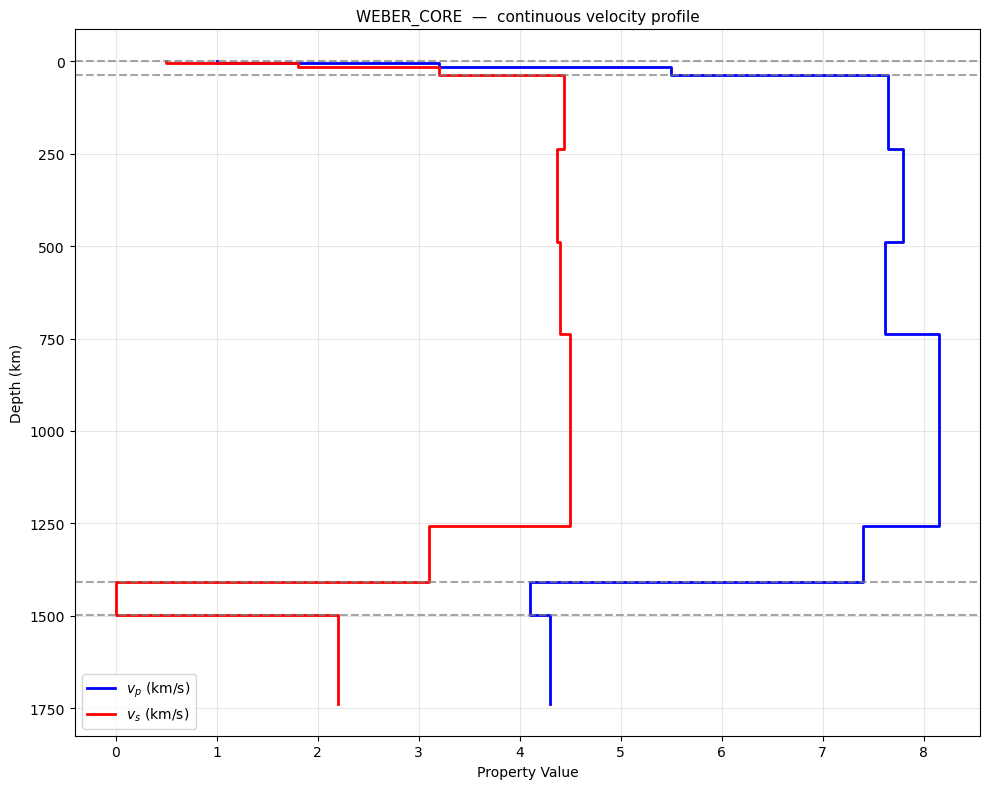

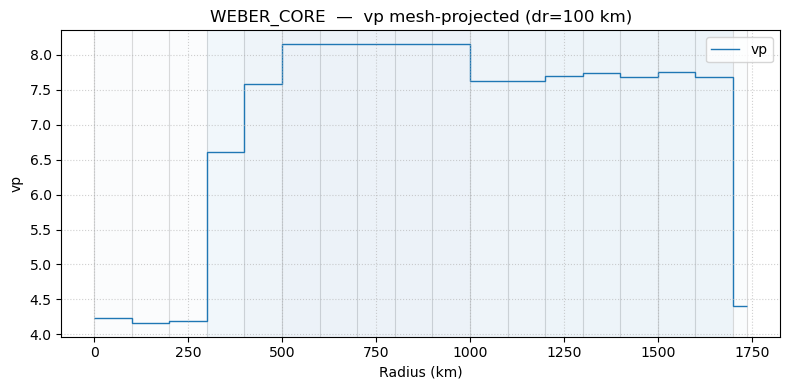

In [5]:

# ── Uniform radial grid: dr = 100 km ─────────────────────────────────────────
DR = 100.0   # shell thickness (km)

mesh_radii = list(np.arange(0.0, model.radius, DR))
if mesh_radii[-1] < model.radius:
    mesh_radii.append(model.radius)

print(f"dr = {DR} km  →  {len(mesh_radii)} boundaries, {len(mesh_radii)-1} shells")

# ── Generate the mesh ─────────────────────────────────────────────────────────
mesh = model.create_mesh('spherical', radii=mesh_radii)
print(f"Mesh: {mesh.mesh.n_cells} shells, {mesh.mesh.n_points} boundaries")

# ── Populate seismic properties ───────────────────────────────────────────────
mesh.populate_properties(['vp', 'vs', 'rho'])
print("Populated: vp, vs, rho")

# ── Continuous model profile (built-in) ──────────────────────────────────────
fig, ax = model.plot_profiles(properties=['vp', 'vs'], show_discontinuities=True)
ax.set_title(f'{model.name}  —  continuous velocity profile', fontsize=11)
plt.tight_layout()
plt.show()

# ── Mesh-projected profile (built-in) ────────────────────────────────────────
fig, ax = mesh.plot_shell_property('vp', show_plot=False,
                                   title=f'{model.name}  —  vp mesh-projected (dr={DR:.0f} km)')
plt.tight_layout()
plt.show()


## 4 · Define stations and events

We place 3 stations at approximate positions of the Apollo ALSEP arrays and 3 synthetic
seismic events at various epicentral distances, covering the range needed for both P
(direct) and PcP (core-reflected) arrivals.


In [6]:
# ── Stations  (Apollo ALSEP approximate positions) ────────────────────────────
stations = {
    'S12': {'lat':   3.04, 'lon': -23.42},   # Apollo 12 — Oceanus Procellarum
    'S14': {'lat':  -3.64, 'lon': -17.48},   # Apollo 14 — Fra Mauro
    'S15': {'lat':  26.13, 'lon':   3.63},   # Apollo 15 — Hadley-Apennine
}

# ── Events (synthetic, on the lunar surface or shallow) ───────────────────────
# Choose positions that give useful epicentral distances (30°–120°)
# relative to the station cluster.
events = {
    'E1': {'lat':  20.0, 'lon':  130.0, 'depth_km': 5.0},   # ~100° from S12
    'E2': {'lat': -40.0, 'lon':  -60.0, 'depth_km': 5.0},   # ~40° from S12
    'E3': {'lat':   5.0, 'lon':  -90.0, 'depth_km': 5.0},   # ~67° from S12
}

# ── Helper: compute great-circle distance (degrees) ───────────────────────────
def gc_distance(lat1, lon1, lat2, lon2):
    """Vincenty great-circle distance in degrees."""
    φ1, λ1 = np.radians(lat1), np.radians(lon1)
    φ2, λ2 = np.radians(lat2), np.radians(lon2)
    Δλ = λ2 - λ1
    a = np.sqrt((np.cos(φ2)*np.sin(Δλ))**2 +
                (np.cos(φ1)*np.sin(φ2) - np.sin(φ1)*np.cos(φ2)*np.cos(Δλ))**2)
    b = np.sin(φ1)*np.sin(φ2) + np.cos(φ1)*np.cos(φ2)*np.cos(Δλ)
    return np.degrees(np.arctan2(a, b))

# ── Print source–receiver table ────────────────────────────────────────────────
print(f"{'Station':>6}  {'Event':>4}  {'Δ (°)':>7}")
print("-" * 24)
for sname, sta in stations.items():
    for ename, evt in events.items():
        dist = gc_distance(sta['lat'], sta['lon'], evt['lat'], evt['lon'])
        print(f"{sname:>6}  {ename:>4}  {dist:7.2f}")


Station  Event    Δ (°)
------------------------
   S12    E1   145.19
   S12    E2    54.54
   S12    E3    66.42
   S14    E1   144.34
   S14    E2    52.82
   S14    E3    72.96
   S15    E1   110.47
   S15    E2    88.72
   S15    E3    91.05


## 5 · Plot stations and events on the lunar surface

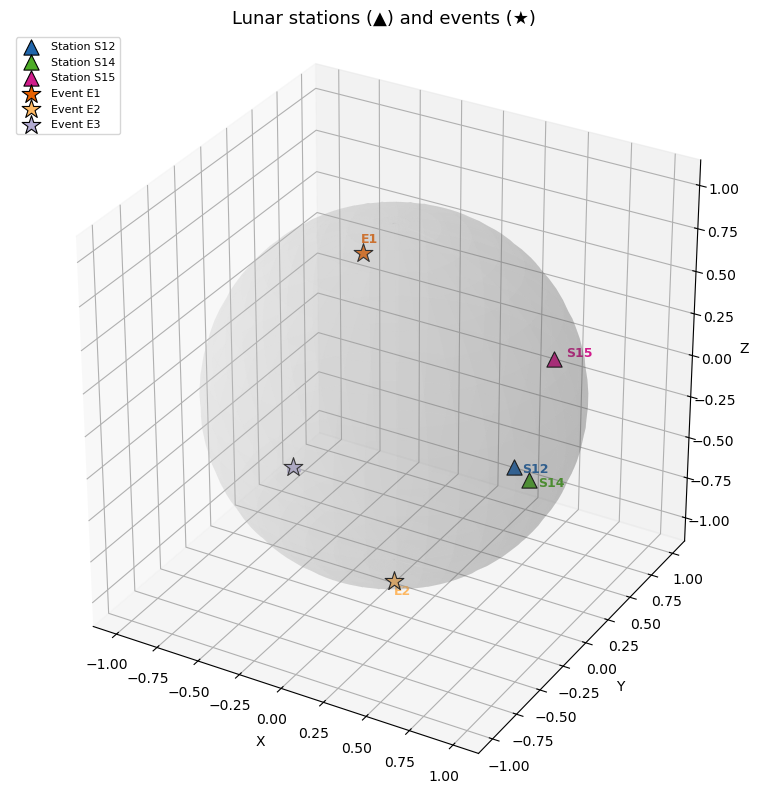

In [7]:
def sph_to_cart(lat_deg, lon_deg, r=1.0):
    """Lat/lon (degrees) → Cartesian on sphere of radius r."""
    lat, lon = np.radians(lat_deg), np.radians(lon_deg)
    x = r * np.cos(lat) * np.cos(lon)
    y = r * np.cos(lat) * np.sin(lon)
    z = r * np.sin(lat)
    return x, y, z

# ── Draw the Moon ─────────────────────────────────────────────────────────────
u = np.linspace(0, 2*np.pi, 80)
v = np.linspace(-np.pi/2, np.pi/2, 40)
uu, vv = np.meshgrid(u, v)
xs = np.cos(vv) * np.cos(uu)
ys = np.cos(vv) * np.sin(uu)
zs = np.sin(vv)

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
ax.plot_surface(xs, ys, zs, rstride=2, cstride=2,
                color='#cccccc', linewidth=0, alpha=0.18)

# ── Stations ──────────────────────────────────────────────────────────────────
sta_colors = ['#2166ac', '#4dac26', '#d01c8b']
for (sname, sta), col in zip(stations.items(), sta_colors):
    x, y, z = sph_to_cart(sta['lat'], sta['lon'])
    ax.scatter(x, y, z, marker='^', s=120, color=col, edgecolors='k',
               linewidths=0.8, zorder=5, label=f'Station {sname}')
    ax.text(x*1.07, y*1.07, z*1.07, sname, fontsize=9,
            color=col, fontweight='bold')

# ── Events ────────────────────────────────────────────────────────────────────
evt_colors = ['#e66101', '#fdb863', '#b2abd2']
for (ename, evt), col in zip(events.items(), evt_colors):
    x, y, z = sph_to_cart(evt['lat'], evt['lon'])
    ax.scatter(x, y, z, marker='*', s=200, color=col, edgecolors='k',
               linewidths=0.8, zorder=5, label=f'Event {ename}')
    ax.text(x*1.07, y*1.07, z*1.07, ename, fontsize=9,
            color=col, fontweight='bold')

# ── Axes labels ───────────────────────────────────────────────────────────────
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Lunar stations (▲) and events (★)', fontsize=13)
ax.legend(loc='upper left', fontsize=8, framealpha=0.8)

for spine in ['top', 'right', 'bottom', 'left']:
    pass  # no 2-D spines in 3-D axes

plt.tight_layout()
plt.show()


## 6 · Compute P and PcP ray paths

For each of the 9 station–event pairs we ask TauPy for **P** and **PcP** arrivals.
Not every pair will produce a PcP ray (shadow zones), so we store only what TauPy
actually returns.


In [8]:

# ── Build TauPy model (cached on first call) ──────────────────────────────────
print("Building TauPy model from weber_core.nd (may take ~10 s)…")
taup = model.taupy_model
print("TauPy model ready.")

# ── Compute all rays ──────────────────────────────────────────────────────────
# rays_catalog: (station, event, phase) -> individual Arrival object
# arrivals_by_pair: (station, event) -> full Arrivals collection (for plotting)
rays_catalog     = {}
arrivals_by_pair = {}

for sname, sta in stations.items():
    for ename, evt in events.items():
        dist_deg = gc_distance(sta['lat'], sta['lon'],
                               evt['lat'], evt['lon'])
        depth_km = evt['depth_km']

        arrivals = taup.get_ray_paths(
            source_depth_in_km=depth_km,
            distance_in_degree=dist_deg,
            phase_list=['P', 'PcP'],
        )

        arrivals_by_pair[(sname, ename)] = arrivals   # full Arrivals object

        # Keep only the first arrival per phase for kernel computation
        found_phases = {}
        for arr in arrivals:
            phase = arr.phase.name
            if phase not in found_phases:
                found_phases[phase] = arr

        for phase, arr in found_phases.items():
            rays_catalog[(sname, ename, phase)] = arr
            print(f"  {sname}–{ename}  {phase:4s}  Δ={dist_deg:6.2f}°  "
                  f"t={arr.time:.1f} s")

print(f"\nTotal rays found: {len(rays_catalog)}")


Building TauPy model from weber_core.nd (may take ~10 s)…
Building obspy.taup model for '/home/adrian/PhD/masters/SensRay/sensray/models/weber_core.nd' ...
filename = /home/adrian/PhD/masters/SensRay/sensray/models/weber_core.nd
Done reading velocity model.
Radius of model . is 1738.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  701 P layers,898 S layers
Done calculating Tau branches.
Done Saving /tmp/weber_core.npz
Method run is done, but not necessarily successful.
TauPy model ready.
  S12–E1  P     Δ=145.19°  t=427.2 s
  S12–E1  PcP   Δ=145.19°  t=436.9 s
  S12–E2  P     Δ= 54.54°  t=218.7 s
  S12–E2  PcP   Δ= 54.54°  t=380.0 s
  S12–E


## 7 · Plot ray paths — ObsPy / TauPy built-in visualization

We use `Arrivals.plot_rays()` from ObsPy's TauPy to render the ray paths.
Each panel shows one station–event pair; the radial axis is the lunar radius
and the angular axis is the epicentral distance from the source.


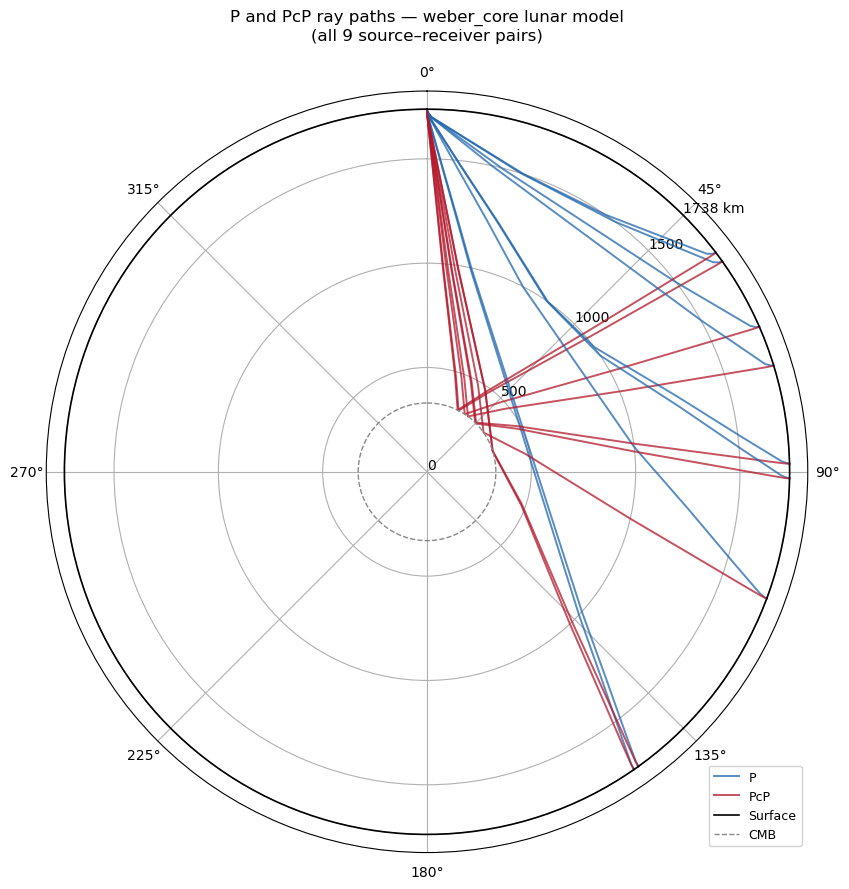

In [16]:

# ── Polar slice plot using TauPy ray-path coordinates ─────────────────────────
LUNAR_R_plot = model.radius   # km — needed for radial axis scaling
CORE_R_plot  = LUNAR_R_plot - 1408.0

phase_colors_ray = {'P': '#2166ac', 'PcP': '#b2182b'}

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

legend_entries = {}

for (sname, ename, phase), arr in rays_catalog.items():
    # TauPy path: dist in radians, depth in km
    theta  = arr.path['dist']          # radians
    radius = LUNAR_R_plot - arr.path['depth']   # km

    color = phase_colors_ray.get(phase, 'gray')
    label = phase if phase not in legend_entries else None
    line, = ax.plot(theta, radius, lw=1.4, color=color,
                    alpha=0.75, label=label)
    if label:
        legend_entries[phase] = line

# ── Reference circles ─────────────────────────────────────────────────────────
theta_full = np.linspace(0, 2 * np.pi, 360)
ax.plot(theta_full, np.full_like(theta_full, LUNAR_R_plot),
        'k-', lw=1.2, label='Surface')
ax.plot(theta_full, np.full_like(theta_full, CORE_R_plot),
        color='#888888', lw=1.0, ls='--', label='CMB')

# ── Radial axis ───────────────────────────────────────────────────────────────
ax.set_rmax(LUNAR_R_plot * 1.05)
ax.set_rmin(0)
ax.set_rlabel_position(45)
ax.set_rticks([0, 500, 1000, 1500, LUNAR_R_plot])
ax.set_yticklabels(['0', '500', '1000', '1500', f'{LUNAR_R_plot:.0f} km'])

ax.set_title('P and PcP ray paths — weber_core lunar model\n'
             '(all 9 source–receiver pairs)', fontsize=12, pad=18)
ax.legend(loc='lower right', fontsize=9, framealpha=0.85)

plt.tight_layout()
plt.show()


## 8 · Compute sensitivity kernels

For each ray we compute the **P-wave travel-time sensitivity kernel**:
$$K_i = -\frac{L_i}{v_P^2(\bar{r}_i) + \epsilon}$$
where $L_i$ is the path length inside shell $i$ and $\bar{r}_i$ is the shell's
mean radius.  The kernel is stored as cell data on the spherical mesh.


In [12]:

LUNAR_R = model.radius          # km
CORE_R  = LUNAR_R - 1408.0     # outer-core radius (CMB depth from weber_core)

# ── Compute a kernel per ray and store results ────────────────────────────────
kernels_dict = {}

for key, arr in rays_catalog.items():
    sname, ename, phase = key
    attach = f"K_{sname}_{ename}_{phase}"
    kernel = mesh.compute_sensitivity_kernel(arr, 'vp', attach_name=attach)
    kernels_dict[key] = kernel
    print(f"  {sname}–{ename} {phase:4s}  max|K|={np.abs(kernel).max():.3e} s/km")

print(f"\nComputed {len(kernels_dict)} kernels.")

# Shell boundary radii / centres / depths for plotting
shell_radii   = np.array(mesh.mesh.radii)
shell_centres = 0.5 * (shell_radii[:-1] + shell_radii[1:])
shell_depths  = LUNAR_R - shell_centres


Stored sensitivity kernel as cell data: 'K_S12_E1_P'
  S12–E1 P     max|K|=7.414e+00 s/km
Stored sensitivity kernel as cell data: 'K_S12_E1_PcP'
  S12–E1 PcP   max|K|=7.963e+00 s/km
Stored sensitivity kernel as cell data: 'K_S12_E2_P'
  S12–E2 P     max|K|=9.821e+00 s/km
Stored sensitivity kernel as cell data: 'K_S12_E2_PcP'
  S12–E2 PcP   max|K|=3.790e+00 s/km
Stored sensitivity kernel as cell data: 'K_S12_E3_P'
  S12–E3 P     max|K|=1.701e+01 s/km
Stored sensitivity kernel as cell data: 'K_S12_E3_PcP'
  S12–E3 PcP   max|K|=3.936e+00 s/km
Stored sensitivity kernel as cell data: 'K_S14_E1_P'
  S14–E1 P     max|K|=9.932e+00 s/km
Stored sensitivity kernel as cell data: 'K_S14_E1_PcP'
  S14–E1 PcP   max|K|=7.881e+00 s/km
Stored sensitivity kernel as cell data: 'K_S14_E2_P'
  S14–E2 P     max|K|=1.015e+01 s/km
Stored sensitivity kernel as cell data: 'K_S14_E2_PcP'
  S14–E2 PcP   max|K|=3.771e+00 s/km
Stored sensitivity kernel as cell data: 'K_S14_E3_P'
  S14–E3 P     max|K|=1.050e+01 s/km



## 9 · Plot sensitivity kernels — all rays overlaid per phase

Two panels: **P** (left) and **PcP** (right).  All 9 rays are overlaid with
distinct colours from a seaborn palette so depth-dependent variations between
different source–receiver pairs are immediately visible.


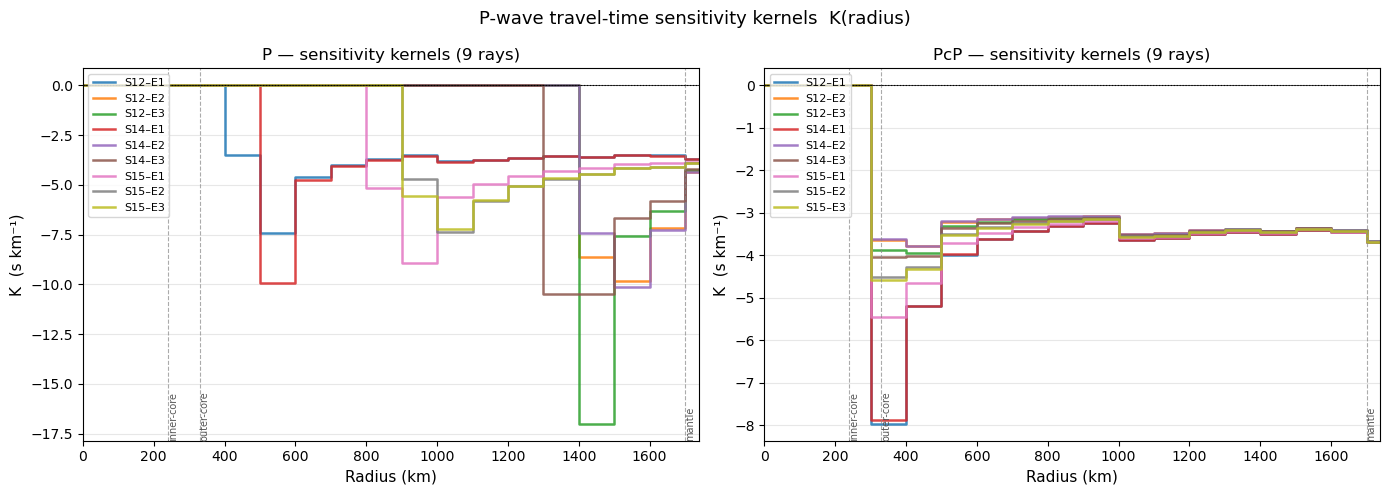

In [17]:

phases_to_plot = ['P', 'PcP']
fig, axes = plt.subplots(1, len(phases_to_plot),
                         figsize=(7 * len(phases_to_plot), 5),
                         sharey=False)

r_bnd = np.array(mesh.mesh.radii)   # ascending boundary radii (km)

disc_radii = {name: LUNAR_R - info['depth']
              for name, info in model.get_discontinuities(outwards=False).items()}

for ax, phase in zip(axes, phases_to_plot):
    phase_keys = [k for k in kernels_dict if k[2] == phase]
    palette    = sns.color_palette('tab10', n_colors=len(phase_keys))

    for color, key in zip(palette, phase_keys):
        sname, ename, _ = key
        kernel = kernels_dict[key]

        # Step-line: for each shell i extend from r_bnd[i] to r_bnd[i+1]
        r_plot = []
        k_plot = []
        for i in range(len(kernel)):
            r_plot.extend([r_bnd[i], r_bnd[i+1]])
            k_plot.extend([kernel[i], kernel[i]])

        ax.plot(r_plot, k_plot, color=color, lw=1.8, alpha=0.85,
                label=f'{sname}–{ename}')

    # Zero line
    ax.axhline(0, color='k', lw=0.8, ls=':')

    # Discontinuity markers (vertical lines — radius on x-axis)
    for disc_name, r_disc in disc_radii.items():
        if 0 < r_disc < LUNAR_R:
            ax.axvline(r_disc, color='#888888', lw=0.8, ls='--', alpha=0.7)
            ax.text(r_disc, ax.get_ylim()[0] if ax.get_ylim()[0] != 0 else 0,
                    disc_name, fontsize=7, color='#555555',
                    va='bottom', ha='left', rotation=90)

    ax.set_xlim(0, LUNAR_R)
    ax.set_xlabel('Radius (km)', fontsize=11)
    ax.set_ylabel('K  (s km⁻¹)', fontsize=11)
    ax.set_title(f'{phase} — sensitivity kernels ({len(phase_keys)} rays)',
                 fontsize=12)
    ax.legend(fontsize=8, loc='upper left', framealpha=0.8)
    ax.grid(True, axis='y', alpha=0.3)
    ax.axhline(0, color='black', lw=0.5)

fig.suptitle('P-wave travel-time sensitivity kernels  K(radius)',
             fontsize=13)
plt.tight_layout()
plt.show()


## 10 · Stacked kernels per phase

Sum all individual kernels for each phase to see the cumulative sensitivity
of the full dataset to P-wave velocity at each depth.


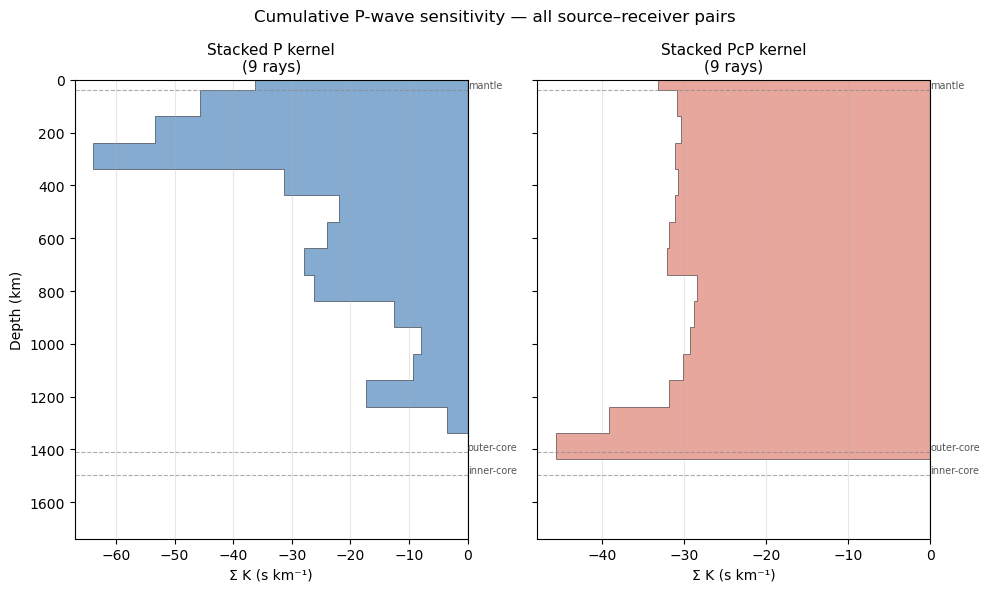

In [18]:

from collections import defaultdict

phase_colors = {'P': '#2166ac', 'PcP': '#d6604d'}

phase_sum = defaultdict(lambda: np.zeros(mesh.mesh.n_cells))
for (sname, ename, phase), kernel in kernels_dict.items():
    phase_sum[phase] += kernel

phases_available = sorted(phase_sum.keys())

disc_depths = {name: info['depth']
               for name, info in model.get_discontinuities(outwards=False).items()}

fig, axes = plt.subplots(1, len(phases_available),
                         figsize=(5 * len(phases_available), 6),
                         sharey=True, squeeze=False)

for col, phase in enumerate(phases_available):
    ax = axes[0][col]
    K_sum = phase_sum[phase]
    color = phase_colors.get(phase, 'steelblue')

    ax.stairs(K_sum, LUNAR_R - shell_radii,
              orientation='horizontal',
              baseline=0,
              fill=True, alpha=0.55,
              color=color, edgecolor='k', linewidth=0.6)
    ax.axvline(0, color='k', lw=0.8)

    for disc_name, d in disc_depths.items():
        if 0 < d < LUNAR_R:
            ax.axhline(d, color='#888888', lw=0.8, ls='--', alpha=0.7)
            ax.text(0, d, disc_name, fontsize=7, color='#555555', va='bottom')

    ax.set_ylim(LUNAR_R, 0)
    ax.set_xlabel('Σ K (s km⁻¹)', fontsize=10)
    if col == 0:
        ax.set_ylabel('Depth (km)', fontsize=10)
    ax.set_title(
        f'Stacked {phase} kernel\n'
        f'({sum(1 for k in kernels_dict if k[2]==phase)} rays)',
        fontsize=11)
    ax.grid(True, axis='x', alpha=0.3)

fig.suptitle('Cumulative P-wave sensitivity — all source–receiver pairs',
             fontsize=12)
plt.tight_layout()
plt.show()
